In [872]:
import gamma as gm
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import basinhopping
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.style as style
style.use('fivethirtyeight')
%config InlineBackend.figure_format ='retina'

In [873]:
from tempfile import NamedTemporaryFile
import urllib.request
import matplotlib.font_manager as fm

def newFont(github_url,sizeFont):
    headers = {}
    headers[
        "User-Agent"
    ] = "Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.27 Safari/537.17"
    url = github_url + '?raw=true'  # You want the actual file, not some html
    request = urllib.request.Request(url, headers=headers)
    response = urllib.request.urlopen(request)
    f = NamedTemporaryFile(delete=False, suffix='.ttf')
    f.write(response.read())
    f.close()    
    return fm.FontProperties(fname=f.name, size=sizeFont)

github_url = 'https://github.com/google/fonts/blob/master/ofl/playfairdisplay/static/PlayfairDisplay-Regular.ttf'
heading_font = newFont(github_url,20)

github_url = 'https://github.com/google/fonts/blob/master/apache/roboto/static/Roboto-Regular.ttf'
subtitle_font = newFont(github_url,16)

In [874]:
def load_dead(districtRegion,start_date):
    dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
    df = pd.read_csv('./data/DRS_mortes.csv',delimiter=',',parse_dates=True, date_parser=dateparse)
    y=[]
    x=[]
    start=datetime.strptime(start_date, "%Y-%m-%d")+timedelta(days=10)
    start2=start.strftime("%Y-%m-%d")
    for i in range(0,len(df.date)):
        y.append(df[districtRegion].values[i])
        x.append(df.date.values[i])
    df2=pd.DataFrame(data=y,index=x,columns=[""])
    df2 =df2.apply (pd.to_numeric, errors='coerce')
    df2[start2:] = df2[start2:].replace({0:np.nan})
    df2 = df2.dropna()
    df2.index = pd.DatetimeIndex(df2.index)
    #interpolate missing data
    df2 = df2.reindex(pd.date_range(df2.index.min(), df2.index.max()), fill_value=np.nan)
    df2 = df2.interpolate(method='akima', axis=0).ffill().bfill()
    #string type for dates and integer for data
    df2 = df2.astype(int)
    df2.index = df2.index.astype(str)
    df2=df2[start_date:]
    return df2

In [875]:
paramFile="data/param_optimized_Yabox_HistMin.csv"
dfparam = pd.read_csv(paramFile)
display(dfparam)
DRS=dfparam.DRS

,DRS,start-date,prediction-range,s0,e0,a0,i0,r0,d0,START,RATIO,WCASES,WREC
0,DRS 01 - Grande São Paulo,2020-03-23,200,16511506,0,0,144,0,54,31,0.15,0.4790,0.0
1,DRS 02 - Araçatuba,2020-04-03,200,238754,0,0,101,0,96,0,0.15,0.4648,0.0
2,DRS 03 - Araraquara,2020-04-01,200,386562,0,0,111,0,115,87,0.15,0.5628,0.0
3,DRS 04 - Baixada Santista,2020-03-31,200,1835503,0,0,174,0,96,121,0.15,0.3407,0.0
4,DRS 05 - Barretos,2020-03-28,200,354163,0,0,209,0,98,26,0.15,0.9069,0.0
5,DRS 06 - Bauru,2020-04-04,200,1781397,0,0,185,0,7,111,0.15,0.1920,0.0
6,DRS 07 - Campinas,2020-04-03,200,4379552,0,0,204,0,5,151,0.15,0.9462,0.0
7,DRS 08 - Franca,2020-04-02,200,706223,0,0,132,0,217,139,0.15,0.9316,0.0
8,DRS 09 - Marília,2020-04-03,200,961264,0,0,18,0,62,173,0.15,0.1901,0.0
9,DRS 10 - Piracicaba,2020-04-02,200,771271,0,0,148,0,134,58,0.15,0.7346,0.0


In [879]:
districtRegion=DRS[0]
display(districtRegion)
start_date=dfparam.loc[dfparam.DRS==districtRegion,'start-date'].values[0]
display(start_date)
dead=load_dead(districtRegion,start_date)

'DRS 01 - Grande São Paulo'

'2020-03-23'

In [880]:
size = len(dead)
tspan=np.arange(0, size, 1)
dead.index=tspan

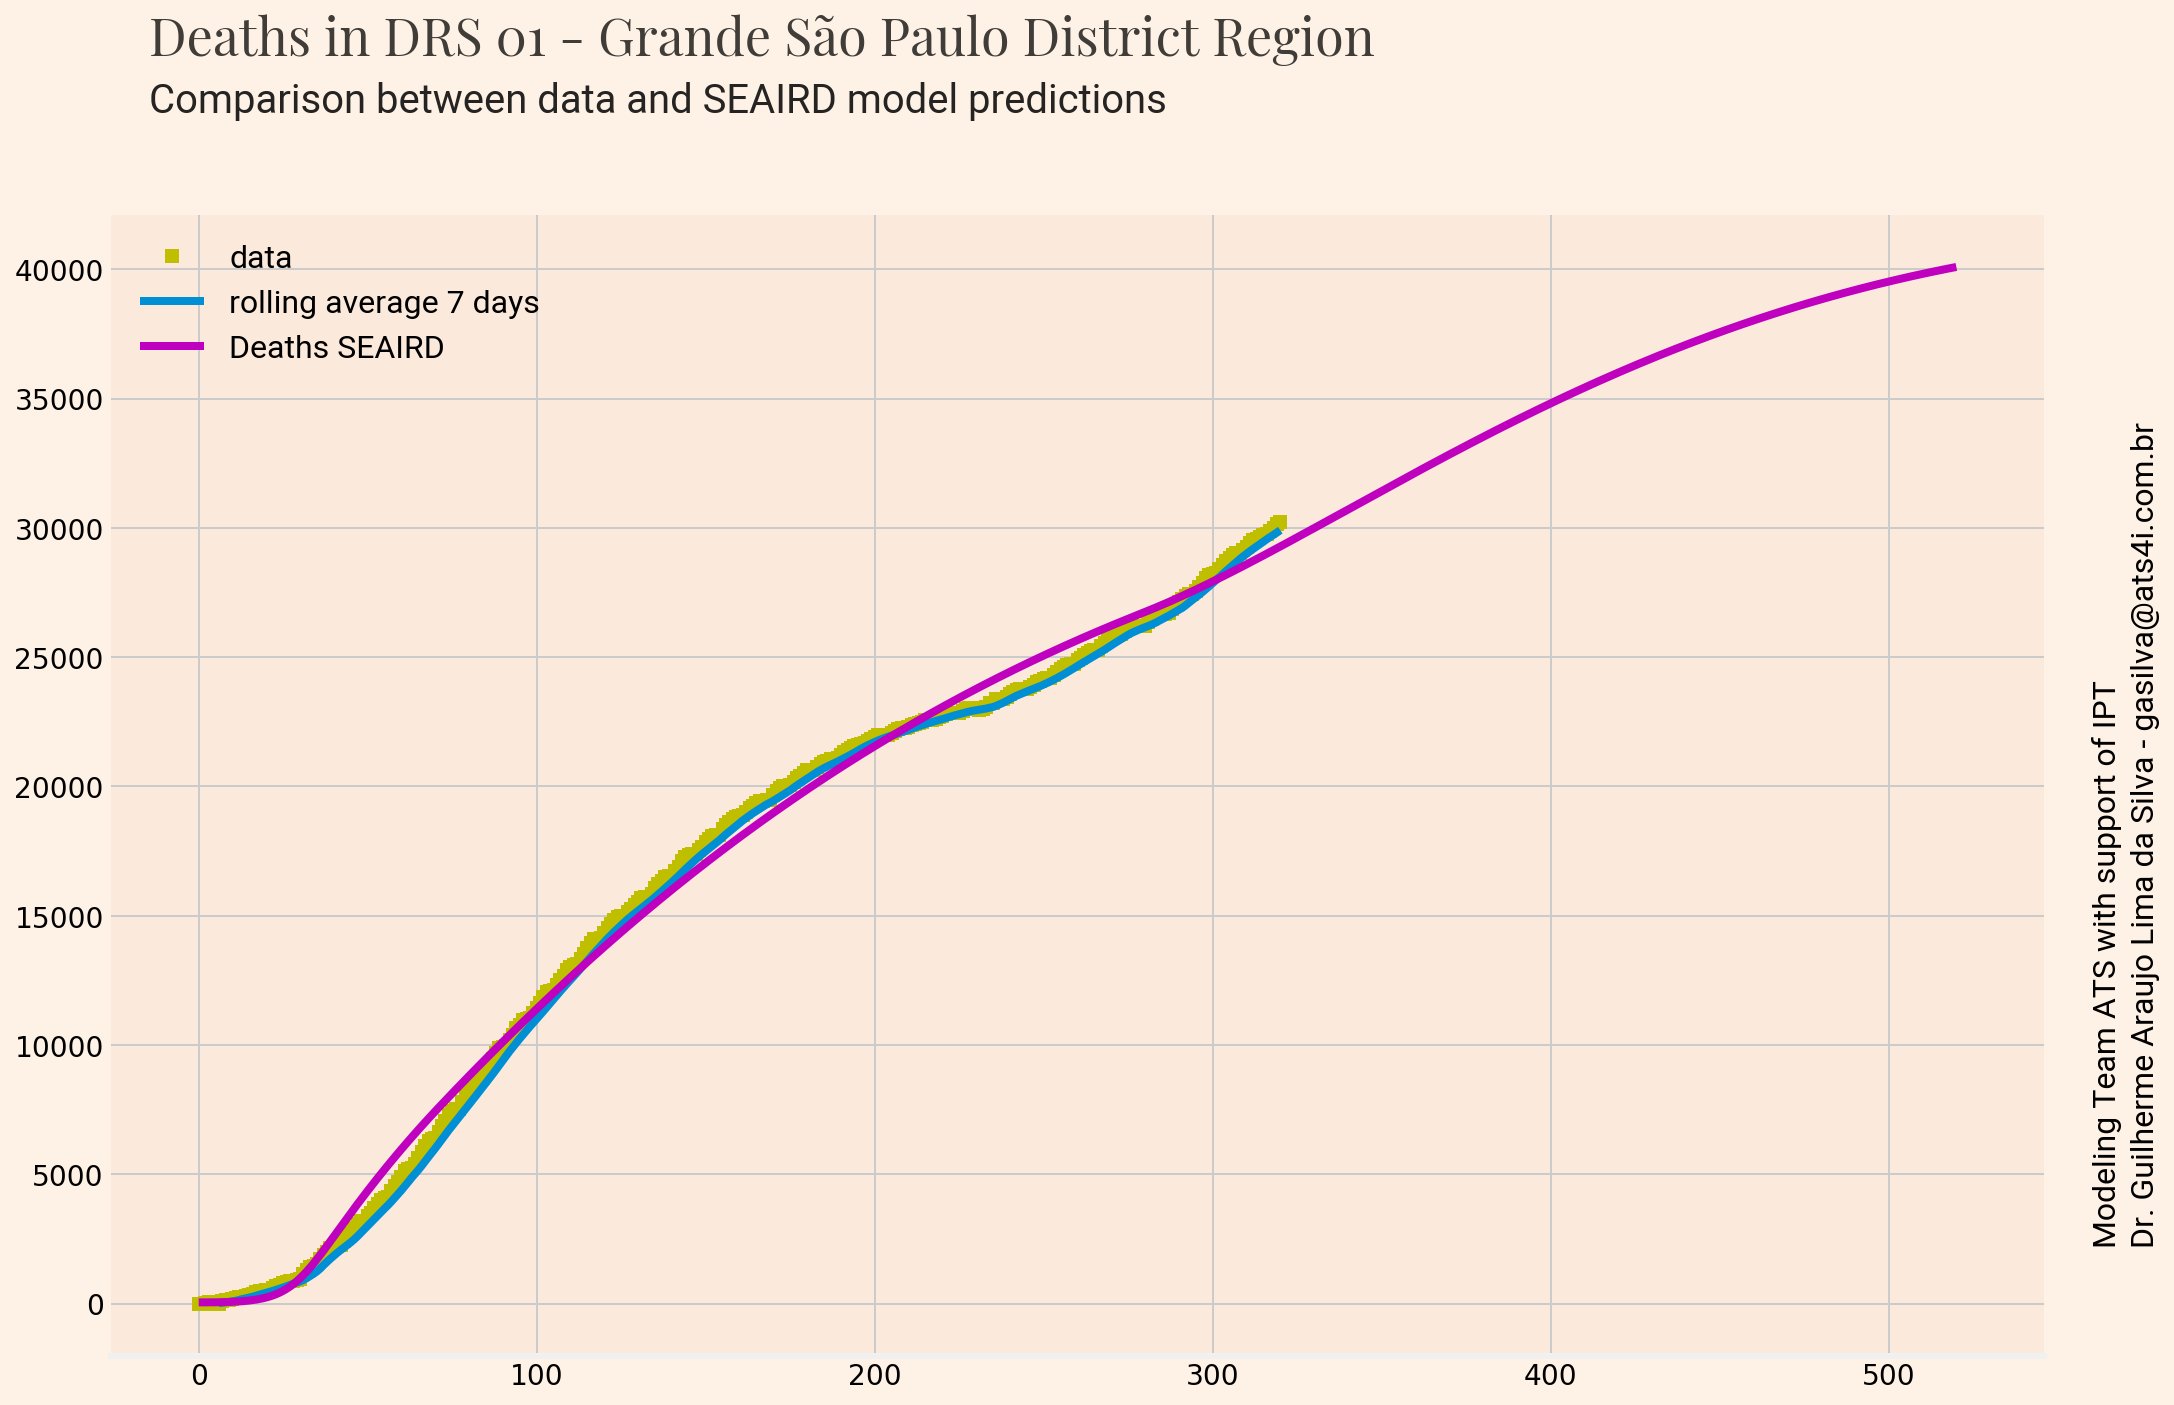

In [881]:
import unicodedata

def plotFT(title,subTitle):
    
    #prepare plotting
    color_bg = '#FEF1E5'
    # lighter_highlight = '#FAE6E1'
    darker_highlight = '#FBEADC'
    plt.rc('font', size=14)
    
    fig, ax = plt.subplots(figsize=(15, 10),facecolor=color_bg)
    ax.patch.set_facecolor(darker_highlight)

    # Adding a title and a subtitle
    ax.text(x = 0.02, y = 1.14, s = title,
                fontsize = 26, weight = 'bold', alpha = .75,transform=ax.transAxes, 
                fontproperties=heading_font)
    ax.text(x = 0.02, y = 1.09,
                s = subTitle,
                fontsize = 20, alpha = .85,transform=ax.transAxes, 
                fontproperties=subtitle_font)

    # Hide the left, right and top spines
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.annotate('Modeling Team ATS with support of IPT', 
    xy=(1.04, 0.1), xycoords='axes fraction',
    xytext=(0, 0), textcoords='offset points',
    ha='right',rotation=90,fontproperties=subtitle_font,fontsize = 16)
    plt.annotate('Dr. Guilherme Araujo Lima da Silva - gasilva@ats4i.com.br', 
    xy=(1.045,0.1), xycoords='axes fraction',
    xytext=(0, 0), textcoords='offset points',
    ha='left',rotation=90,fontproperties=subtitle_font,fontsize = 16)

    fig.tight_layout()
    
    return fig,ax
    

def loadDataFrame(filename):
    df= pd.read_pickle(filename)
    df.columns = [c.lower().replace(' ', '_') for c in df.columns]
    df.columns = [c.lower().replace('(', '') for c in df.columns]
    df.columns = [c.lower().replace(')', '') for c in df.columns]
    return df

def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text)

dR = strip_accents(districtRegion)
df = loadDataFrame('./data/SEAIRD_sigmaOpt_'+dR+'.pkl')

fig,ax = plotFT("Deaths in "+districtRegion+" District Region","Comparison between data and SEAIRD model predictions")

ax.plot(tspan,dead.iloc[:,0].values,'ys',label='data')
ax.plot(dead.iloc[:,0].rolling(7).mean(),'-',label='rolling average 7 days')
tspan3=np.arange(0, len(df['deaths'].values), 1)
ax.plot(tspan3,df['deaths'].values,'m-',label="Deaths SEAIRD")
leg=ax.legend(frameon=False,fontsize=16,prop=subtitle_font)



In [882]:
display()

diffDead=np.diff(dead.iloc[:,0].T[:])
diffDead=np.insert(diffDead,0,0)
dead['diff']=diffDead
display(dead)

,,diff
0,0,0
1,0,0
2,48,48
3,56,8
4,66,10
...,...,...
316,29781,69
317,29870,89
318,29992,122
319,30143,151


,,diff
0,0,0
1,0,0
2,48,48
3,56,8
4,66,10
...,...,...
316,29781,69
317,29870,89
318,29992,122
319,30143,151


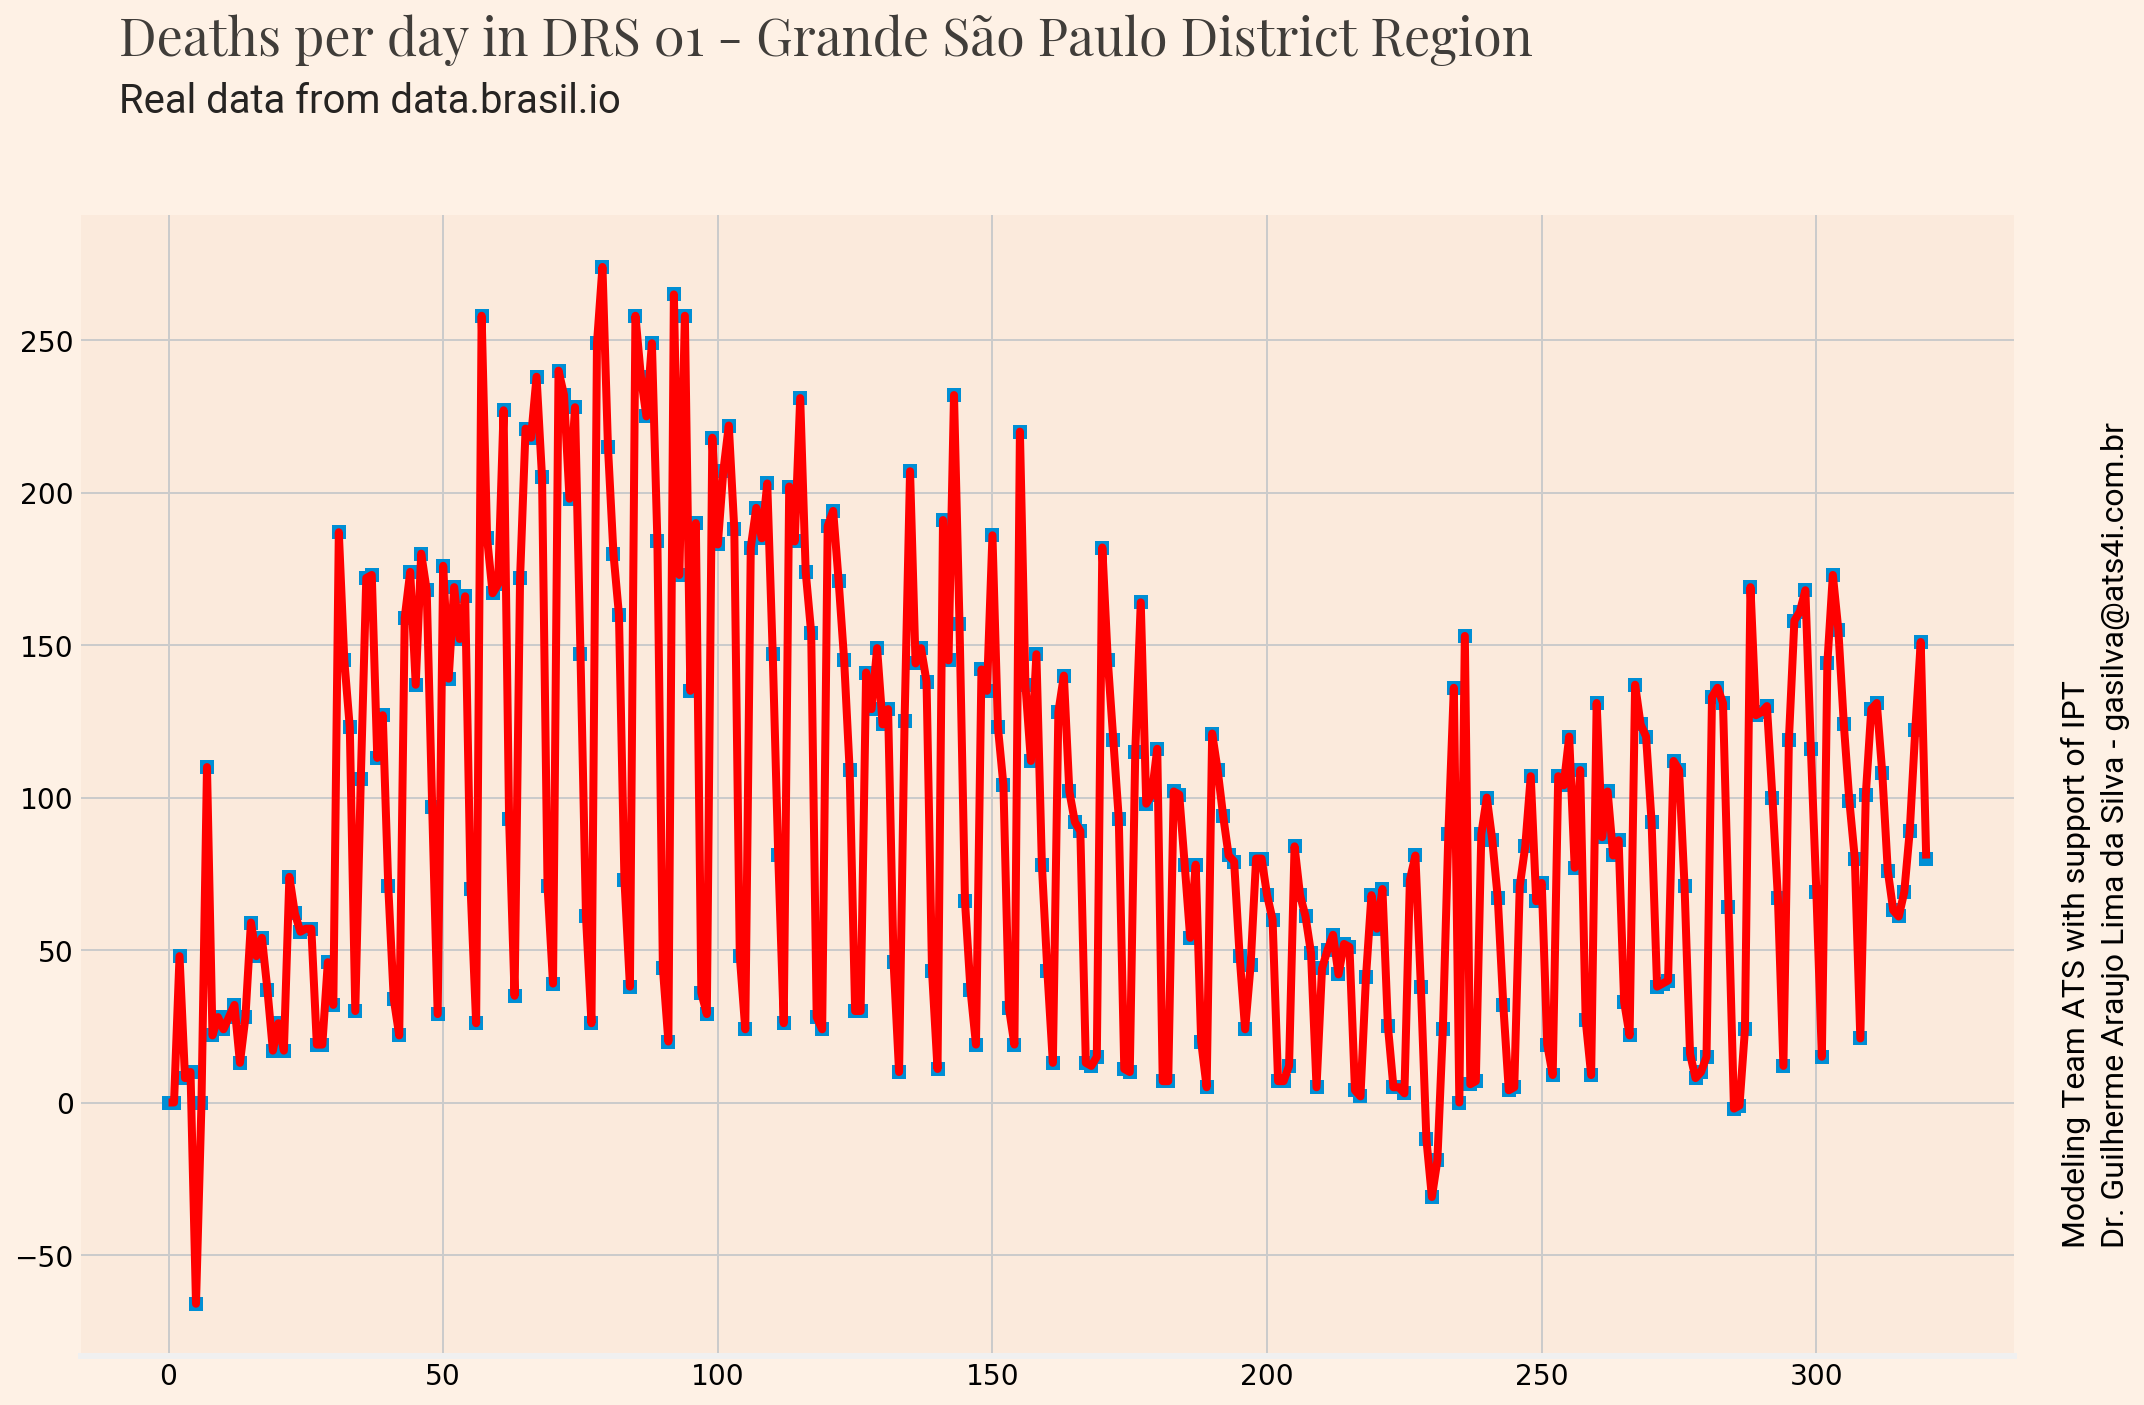

In [883]:
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()

regr.fit([dead.index.values.T], [dead['diff'].values])

tspan1=np.arange(0, size, 1)
results = regr.predict([tspan1])

display(dead)

fig,ax = plotFT("Deaths per day in "+districtRegion+" District Region","Real data from data.brasil.io")
ax.plot(dead['diff'],'s')
ax.plot(tspan1,results[0],'r-')



In [884]:

# ARIMA example
from statsmodels.tsa.arima.model import ARIMA
from random import random
# contrived dataset
data = dead['diff'].values
# fit model
model = ARIMA(data, order=(5, 1, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data), typ='levels')
print(yhat)
pred=model_fit.get_forecast(steps=300).predicted_mean

[62.59209992]


array([ -0.12776274, 114.59468664])

array([ 5.90431293, 50.0177099 ,  2.78498869, 94.150411  ])

100%|██████████| 500/500 [00:02<00:00, 189.67trial/s, best loss: 10417.525114466549]


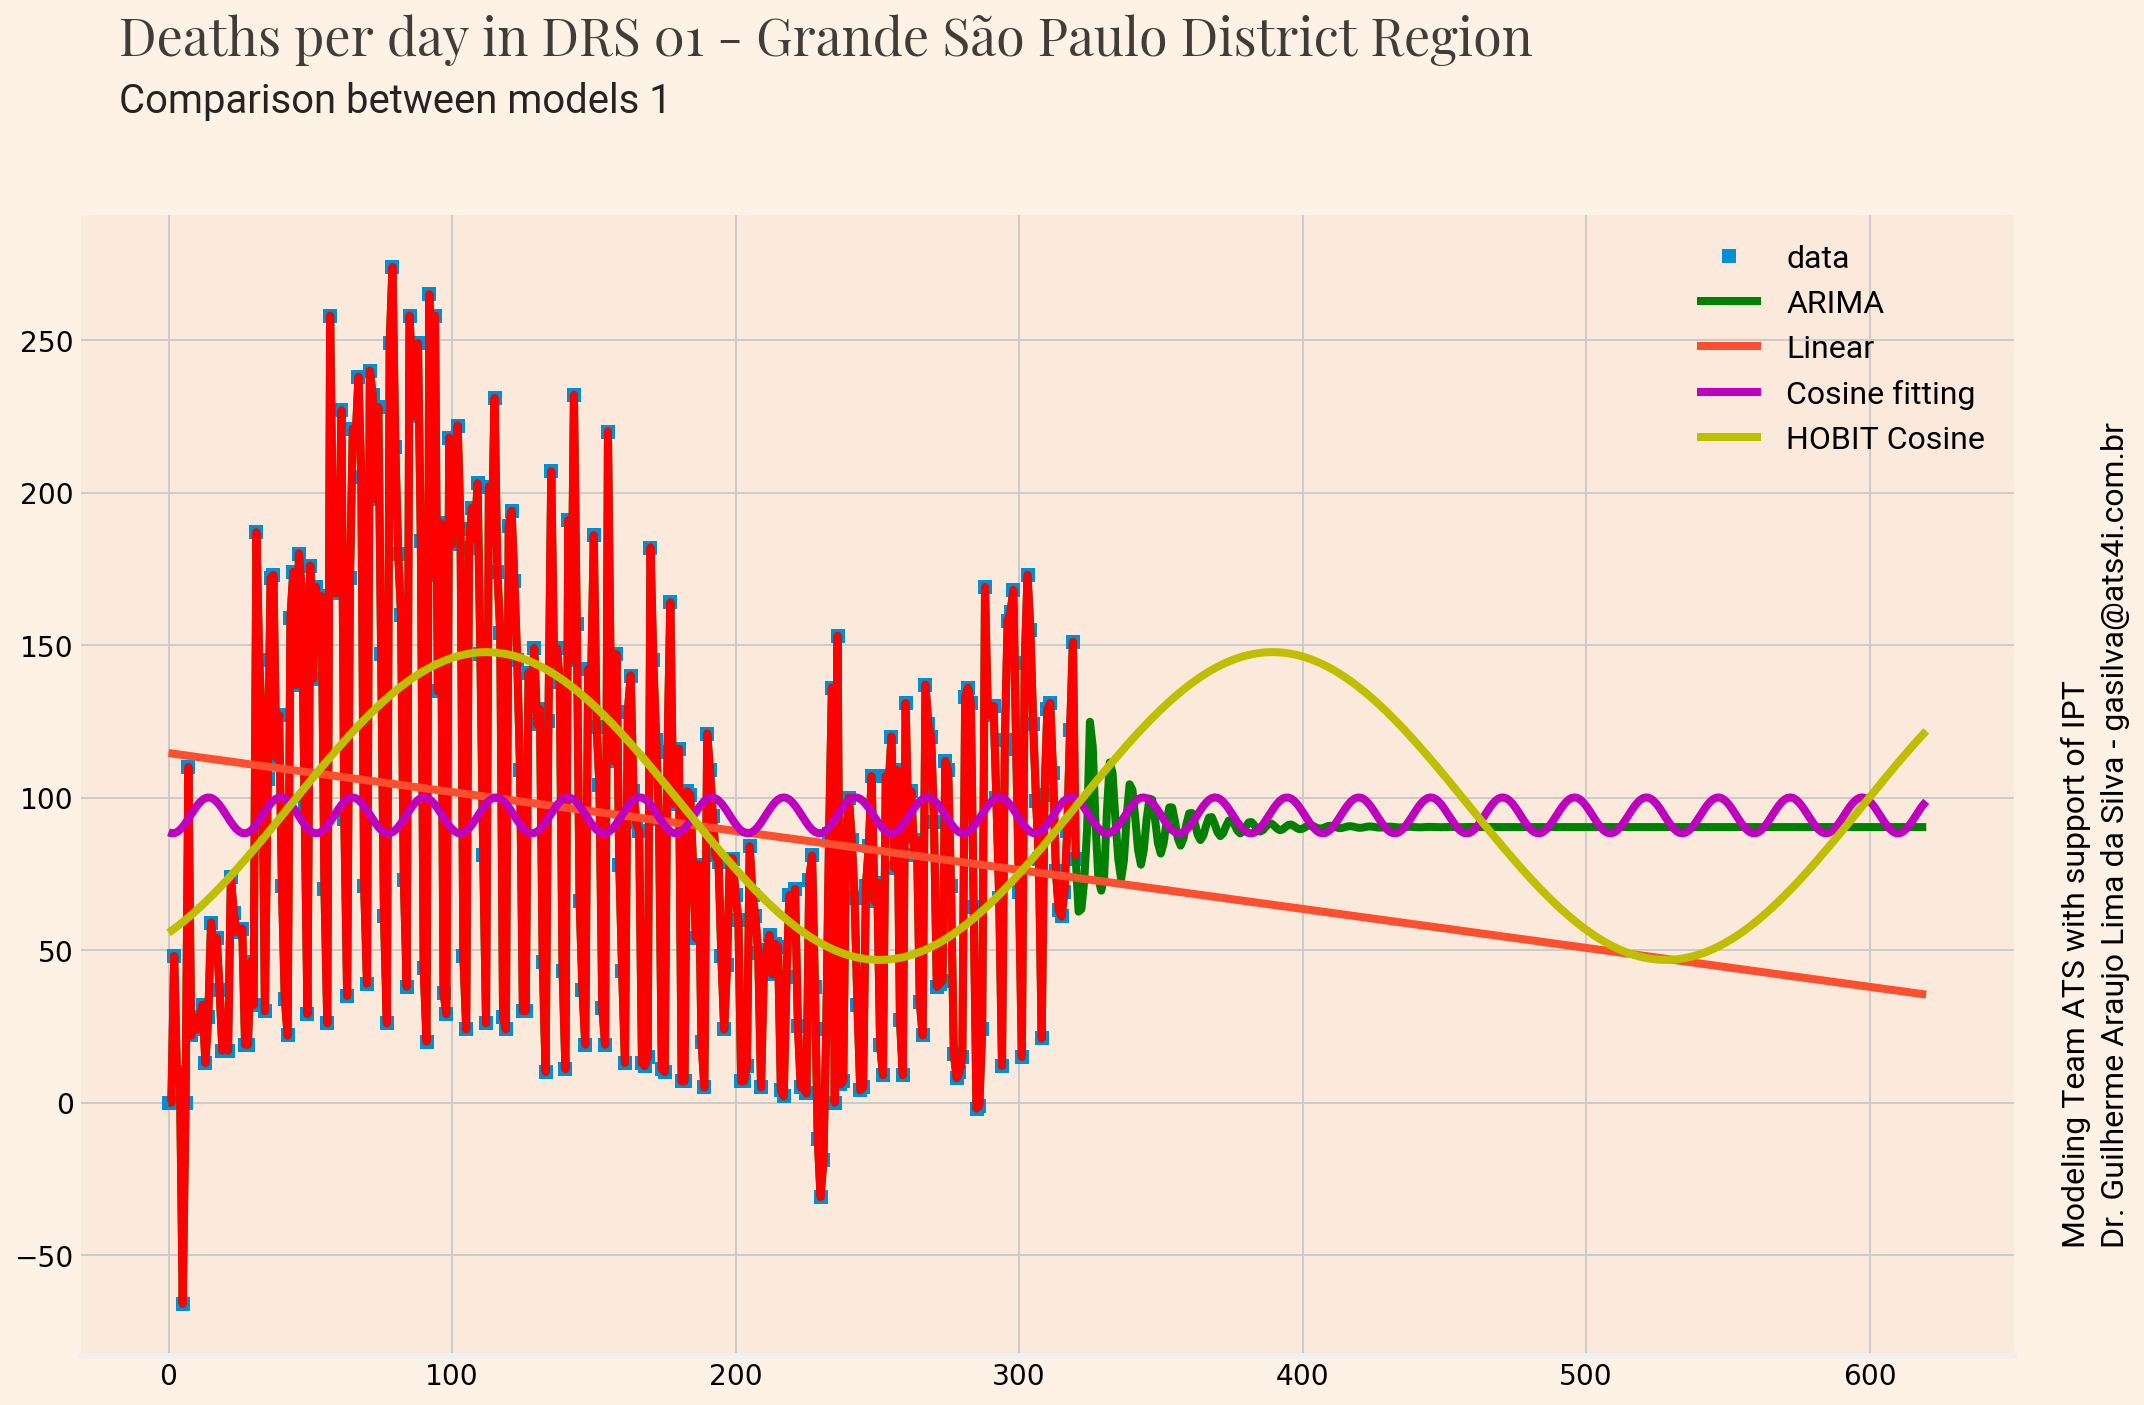

In [885]:
from scipy.optimize import curve_fit

fig,ax = plotFT("Deaths per day in "+districtRegion+" District Region","Comparison between models 1")

ax.plot(dead['diff'],'s',label="data")
tspan2=np.arange(0, size+300, 1)
pred2=np.append(dead.iloc[:,1].values,pred)
ax.plot(tspan2,pred2,'g-',label="ARIMA")
ax.plot(tspan1,results[0],'r-')

coef=np.polyfit(tspan, dead.iloc[:,1].values, 1)
display(coef)
pred3=tspan2*coef[0]+coef[1]
ax.plot(tspan2,pred3,label="Linear")

def deadFit(data,a,b,c,d):
    return a*np.cos(b*data-c)+d

fittedParameters, pcov =curve_fit(deadFit, tspan, dead.iloc[:,1].values,
                                 bounds=((0, 0, -np.pi, 0), (200, 100, np.pi, 200)))

display(fittedParameters)

a, b, c, d = fittedParameters

pred4=deadFit(tspan2,a,b,c,d)
ax.plot(tspan2,pred4,'m',label="Cosine fitting")

from HOBIT import RegressionForTrigonometric
from IPython.display import display, Math

seed = 12345512
trig_reg = RegressionForTrigonometric()
trig_reg.fit_cos(tspan, dead.iloc[:,1].values, max_evals=500, rstate=np.random.RandomState(seed))

trig_reg.best_parameters

y3 = trig_reg.predict(tspan2)
ax.plot(tspan2,y3,'y',label="HOBIT Cosine")
leg=ax.legend(frameon=False,fontsize=16,prop=subtitle_font)


In [886]:
from sklearn.metrics import mean_squared_error, r2_score
from hyperopt import hp, tpe, Trials, fmin
y_data=dead.iloc[:,1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tspan, y_data, test_size=0.2, random_state=42)
ix=np.where(y_train>0)
X_train=X_train[ix]
y_train=y_train[ix]

In [887]:
def objective(a0, a1, w, f, gamma):
    """Objective function to minimize"""
    return np.mean((a0+ a1 * np.exp(-gamma*X_train)*np.cos(w*X_train + f) - y_train)**2)

In [888]:
def objective2(args):
    return objective(*args)

def objective3(p):
    a0, a1, w, f, gamma = p
    return np.mean((a0+ a1 * np.exp(-gamma*X_train)*np.cos(w*X_train + f) - y_train)**2)

def objective4(p):
    a0, a1, gamma = p
    ix=np.where(y_train>0)
    sol=a0-a1*np.exp(-gamma*X_train[ix])
#     sol=np.maximum(sol,0)
    return np.mean((sol - y_train[ix])**2)

def objective5(p,t):
    a0, a1, gamma = p
    return (a0-a1*np.exp(-gamma*t))


In [889]:
space = [hp.uniform('a0', 0, 200),
         hp.uniform('a1', 0, 200), 
         hp.uniform('w', 0, 0.5), 
         hp.uniform('f', -np.pi, np.pi),
         hp.uniform('gamma',0,0.0000125)
        ]

tpe_algo = tpe.suggest
tpe_trials = Trials()

tpe_best = fmin(fn=objective2, space=space, algo=tpe_algo, trials=tpe_trials, max_evals=500, rstate=np.random.RandomState(seed))

print(tpe_best)

100%|██████████| 500/500 [00:06<00:00, 83.31trial/s, best loss: 3194.507775191078] 
{'a0': 91.9222892303633, 'a1': 67.7678191571768, 'f': -2.252554845919035, 'gamma': 2.142879024814582e-06, 'w': 0.023159825243277494}


In [890]:
x_data=tspan2
y = tpe_best['a0'] + np.exp(-tpe_best['gamma']*x_data)*tpe_best['a1'] * np.cos(tpe_best['w'] * x_data + tpe_best['f'])

In [891]:
bnds = ((0,200),(0,200),(0,1))
x0 = [50,50,0.001]
minimizer_kwargs = { "method": "L-BFGS-B","bounds":bnds }
optimal = basinhopping(objective4, x0, minimizer_kwargs=minimizer_kwargs,niter=100) 
print(optimal.x)
print(optimal.fun)

[1.02519551e+02 1.42701319e+02 7.28625457e-02]
4435.916494340548


In [892]:
y2=objective5(optimal.x,tspan2)

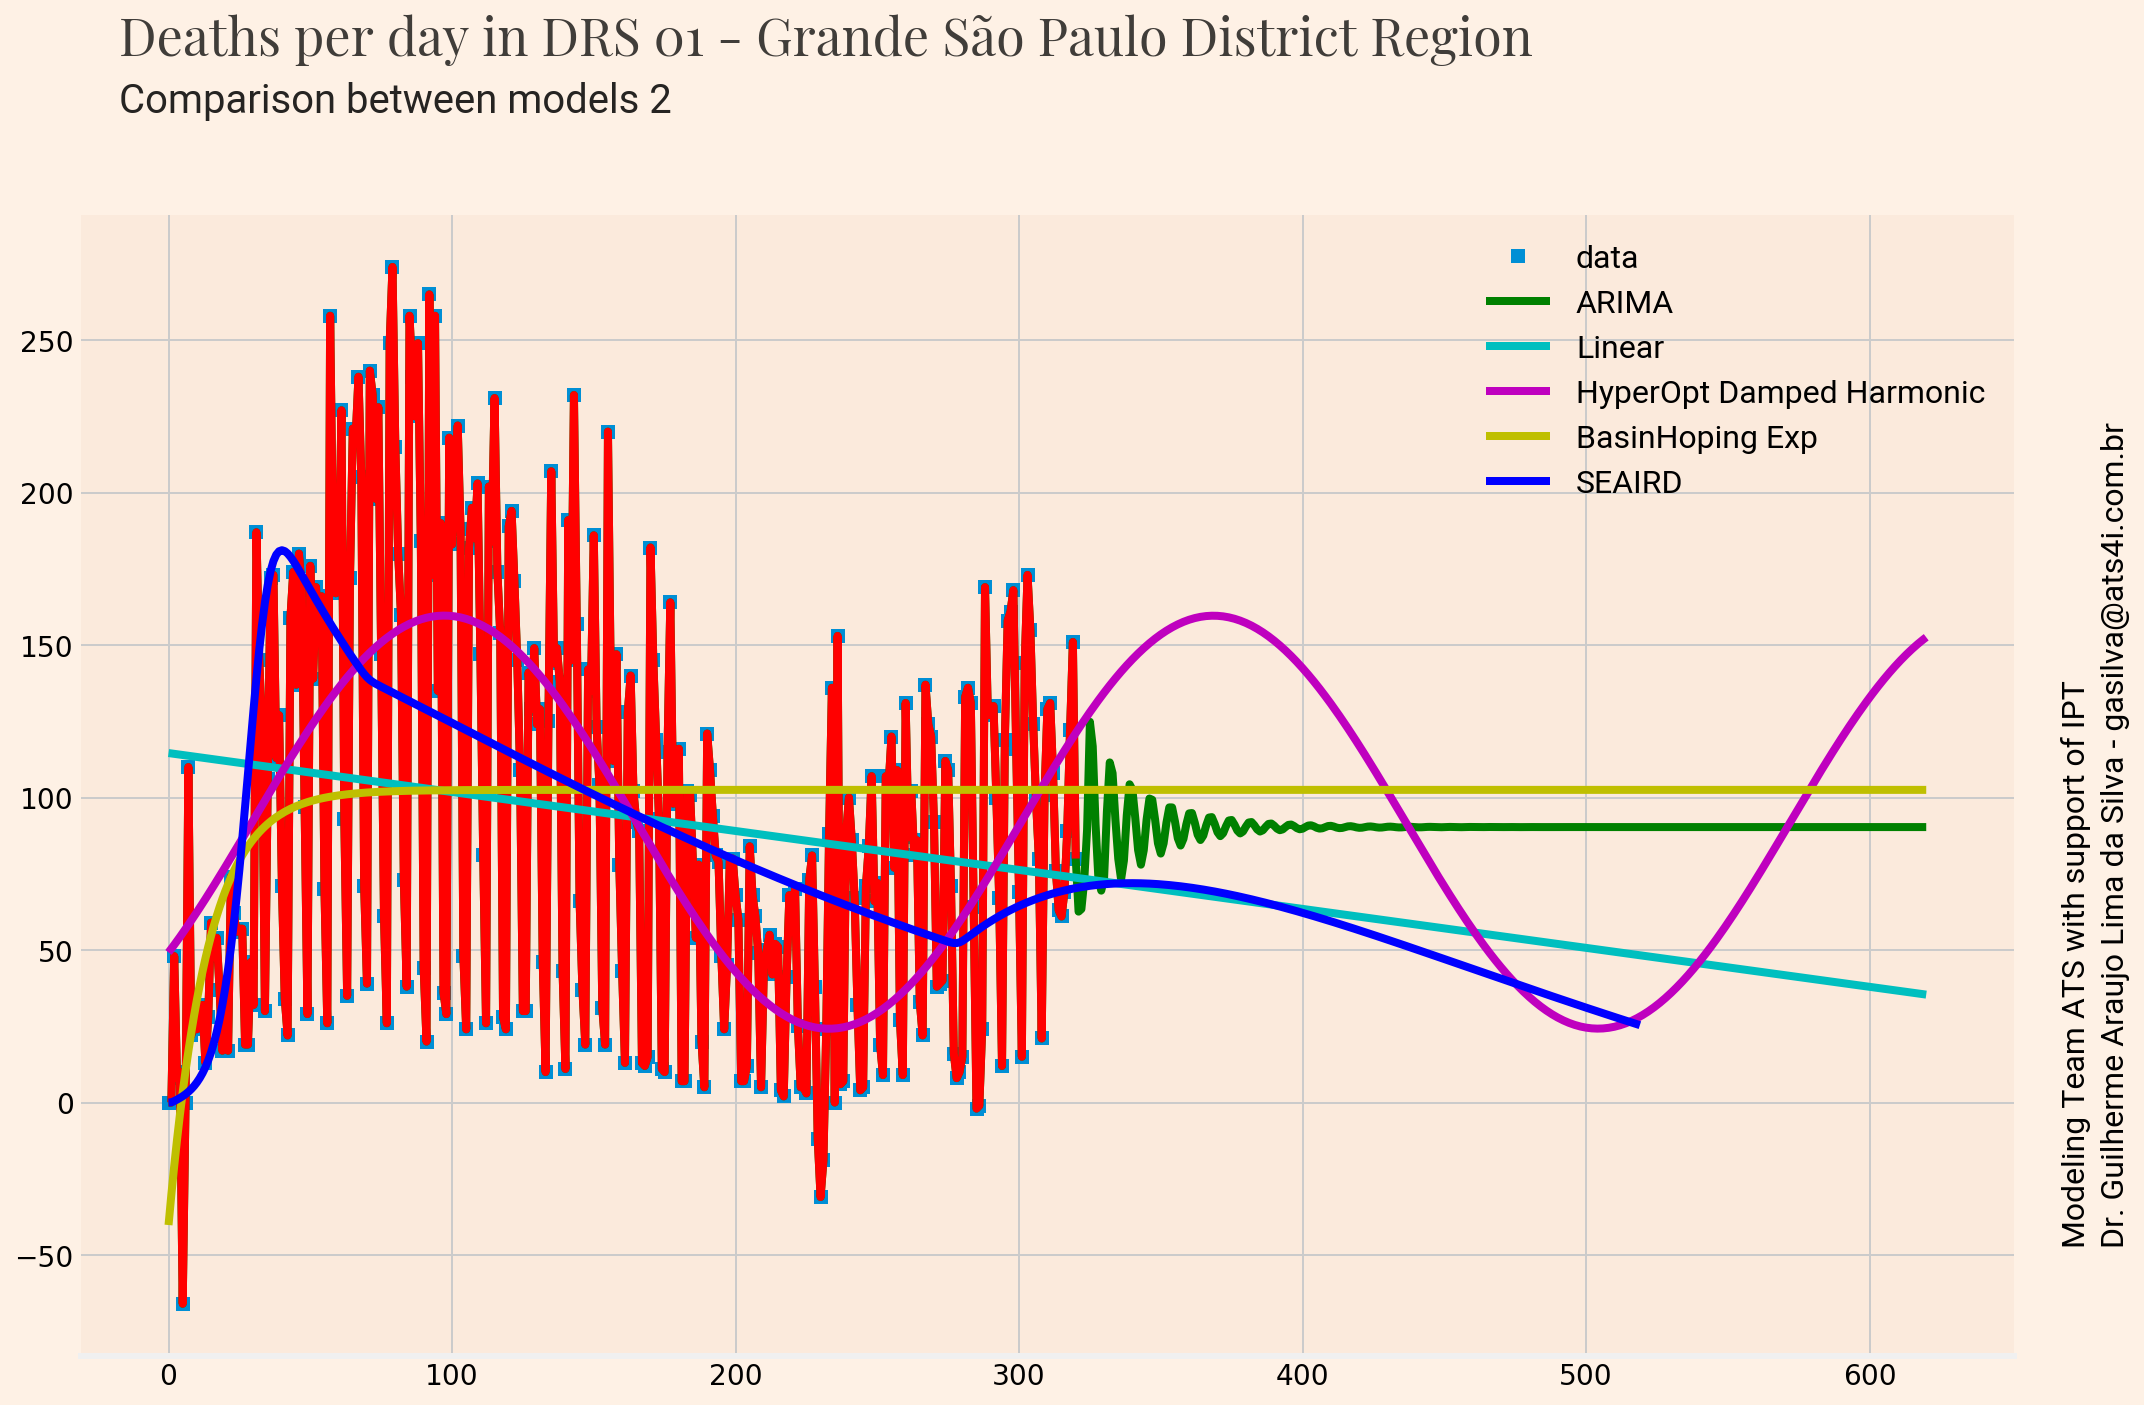

In [893]:
fig,ax = plotFT("Deaths per day in "+districtRegion+" District Region","Comparison between models 2")


ax.plot(dead['diff'],'s',label='data')
tspan2=np.arange(0, size+300, 1)
pred2=np.append(dead.iloc[:,1].values,pred)
ax.plot(tspan2,pred2,'g-',label='ARIMA')
ax.plot(tspan1,results[0],'r-')

pred3=tspan2*coef[0]+coef[1]
ax.plot(tspan2,pred3,'c-',label='Linear')

# ax.plot(tspan2,pred4,'b',label='cosine')

ax.plot(tspan2,y,'m',label='HyperOpt Damped Harmonic')

ax.plot(tspan2,y2,'y',label='BasinHoping Exp')

diffDeaths=np.diff(df['deaths'].values)

size4=len(diffDeaths)

ax.plot(np.arange(0, size4, 1),diffDeaths,'b',label='SEAIRD')


leg=ax.legend(frameon=False,fontsize=16,prop=subtitle_font)


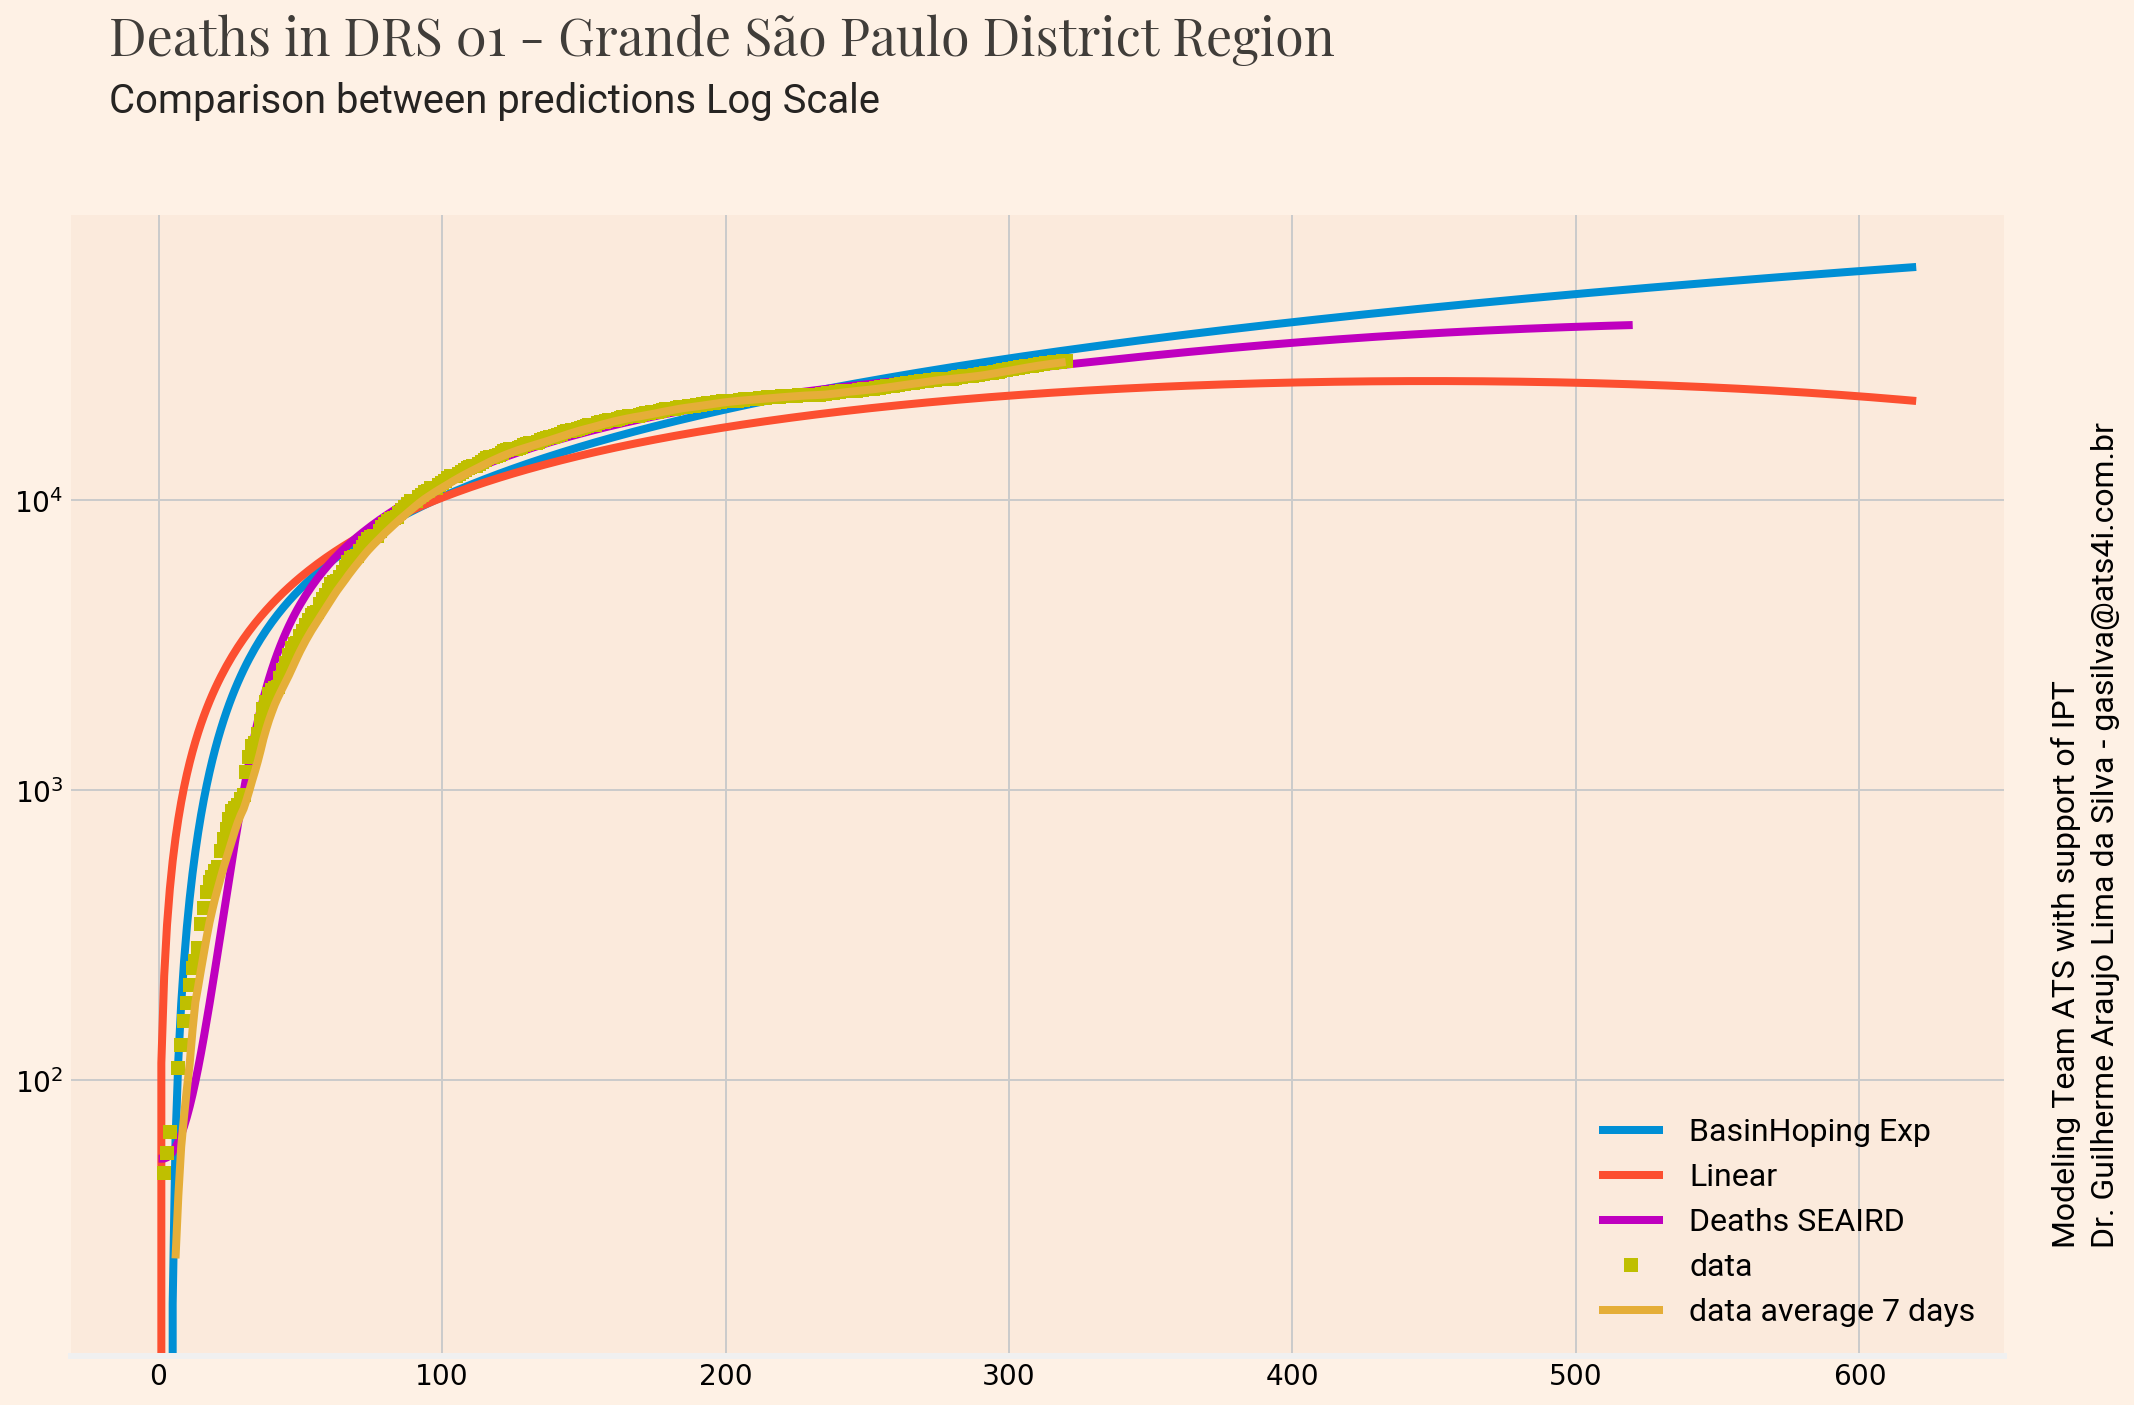

In [894]:
fig,ax = plotFT("Deaths in "+districtRegion+" District Region","Comparison between predictions Log Scale")

# ax.plot(tspan2,pred2*tspan2,label='ARIMA')
tspan3=np.arange(0, len(df['deaths'].values), 1)
ax.plot(tspan2,y2*tspan2,label='BasinHoping Exp')
ax.plot(tspan2,pred3*tspan2,label='Linear')
# ax.plot(tspan2,y*tspan2,label='HyperOpt Damped Harmonic')
ax.plot(tspan3,df['deaths'].values,'m-',label="Deaths SEAIRD")
ax.plot(tspan,dead.iloc[:,0].values,'ys',label='data')
ax.plot(dead.iloc[:,0].rolling(7).mean(),'-',label='data average 7 days')

ax.set_yscale('log')
leg=ax.legend(frameon=False,fontsize=16,prop=subtitle_font)
